In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img,load_img
from keras.models import Sequential, Model
from keras.models import load_model
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
import time
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
path="Dataset/"

In [3]:
metaData=pd.read_excel(path+"styles.xlsx")
print(metaData.columns)

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')


In [4]:
final=metaData.loc[metaData['masterCategory'].isin(['Accessories','Apparel','Footwear'])]
final.articleType.value_counts()

Tshirts               7068
Shirts                3212
Casual Shoes          2846
Watches               2541
Sports Shoes          2035
                      ... 
Tablet Sleeve            3
Lounge Tshirts           3
Rain Trousers            2
Key chain                2
Ties and Cufflinks       2
Name: articleType, Length: 104, dtype: int64

In [5]:
temp=final.articleType.value_counts()

In [6]:
dropList=[]
for i in range(len(temp)):
    if(temp[i]>20):
        dropList.append(temp.index[i])

In [7]:
dropList

['Tshirts',
 'Shirts',
 'Casual Shoes',
 'Watches',
 'Sports Shoes',
 'Kurtas',
 'Tops',
 'Handbags',
 'Heels',
 'Sunglasses',
 'Wallets',
 'Flip Flops',
 'Sandals',
 'Briefs',
 'Belts',
 'Backpacks',
 'Socks',
 'Formal Shoes',
 'Jeans',
 'Shorts',
 'Trousers',
 'Flats',
 'Bra',
 'Dresses',
 'Sarees',
 'Earrings',
 'Track Pants',
 'Clutches',
 'Sweatshirts',
 'Caps',
 'Sweaters',
 'Jackets',
 'Ties',
 'Innerwear Vests',
 'Kurtis',
 'Tunics',
 'Nightdress',
 'Leggings',
 'Pendant',
 'Capris',
 'Necklace and Chains',
 'Night suits',
 'Trunk',
 'Skirts',
 'Ring',
 'Dupatta',
 'Scarves',
 'Accessory Gift Set',
 'Cufflinks',
 'Kurta Sets',
 'Stoles',
 'Duffel Bag',
 'Bangle',
 'Laptop Bag',
 'Sports Sandals',
 'Bracelet',
 'Lounge Pants',
 'Jewellery Set',
 'Boxers',
 'Mobile Pouch',
 'Messenger Bag',
 'Suspenders',
 'Camisoles',
 'Patiala',
 'Mufflers',
 'Lounge Shorts',
 'Jeggings',
 'Stockings',
 'Salwar',
 'Churidar',
 'Tracksuits',
 'Shoe Accessories']

# Preprocessing Dataset

In [8]:
final=final.loc[final['articleType'].isin(dropList)]
final.articleType.value_counts()

Tshirts             7068
Shirts              3212
Casual Shoes        2846
Watches             2541
Sports Shoes        2035
                    ... 
Stockings             32
Salwar                32
Churidar              30
Tracksuits            29
Shoe Accessories      24
Name: articleType, Length: 72, dtype: int64

In [9]:
X=[(str(x)+".jpg") for x in final["id"]]
Y=final["articleType"]

In [70]:
X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=0.33, stratify=Y)

In [71]:
preprocess=ImageDataGenerator(rescale=1./255)
traindf=pd.DataFrame(np.column_stack([X_train,Y_train]), columns=['FileName', 'articleType'])
testdf=pd.DataFrame(np.column_stack([X_test,Y_test]), columns=['FileName', 'articleType'])

In [72]:
batch_size=100

In [73]:
trainData = preprocess.flow_from_dataframe(
    dataframe=traindf,
    directory=path+'images/',
    x_col = 'FileName',
    y_col = 'articleType',
    target_size = (64,64),
    batch_size=batch_size,
    shuffle=False
 )


Found 27863 validated image filenames belonging to 72 classes.


In [74]:
testData = preprocess.flow_from_dataframe(
    dataframe=testdf, 
    directory=path+'images/',
    x_col = 'FileName', 
    y_col = 'articleType', 
    target_size = (64,64),
    batch_size=1,
    shuffle=False
  )

Found 13725 validated image filenames belonging to 72 classes.


# Model Creation

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(64,64,3)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Dropout(0.25))
# model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
# model.add(LeakyReLU(alpha=0.1))                  
# model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))           
model.add(Dropout(0.3))
model.add(Dense(len(trainData.class_indices), activation='softmax'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

# Model compile and train

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("articleType_model.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')


In [75]:
start = time.time()
hist = model.fit_generator(
    generator=trainData, 
    steps_per_epoch=int(np.ceil(trainData.n/batch_size)), 
    validation_data=testData, 
    validation_steps=int(np.ceil(testData.n/batch_size)),
    epochs=20,
    callbacks=[checkpoint,early],
    verbose=1
  )
end = time.time()
print('Time:',(end - start)/60)

Epoch 1/20
279/279 [==============================] - 640s 2s/step - loss: 0.4277 - accuracy: 0.8710 - val_loss: 0.0096 - val_accuracy: 0.8768

Epoch 00001: val_accuracy did not improve from 0.91304
Epoch 2/20
279/279 [==============================] - 173s 621ms/step - loss: 0.3666 - accuracy: 0.8810 - val_loss: 0.0000e+00 - val_accuracy: 0.9203

Epoch 00002: val_accuracy improved from 0.91304 to 0.92029, saving model to model_1.h5
Epoch 3/20
279/279 [==============================] - 187s 670ms/step - loss: 0.3363 - accuracy: 0.8872 - val_loss: 0.0077 - val_accuracy: 0.9058

Epoch 00003: val_accuracy did not improve from 0.92029
Epoch 4/20
279/279 [==============================] - 206s 737ms/step - loss: 0.3094 - accuracy: 0.8938 - val_loss: 4.7684e-07 - val_accuracy: 0.8841

Epoch 00004: val_accuracy did not improve from 0.92029
Epoch 5/20
279/279 [==============================] - 210s 754ms/step - loss: 0.2843 - accuracy: 0.9011 - val_loss: 0.5934 - val_accuracy: 0.8696

Epoch 00

# Model Evaluate

In [105]:
model_evaluate=model.evaluate_generator(generator=testData,verbose=1)
print('Test loss:', model_evaluate[0])
print('Test accuracy:', model_evaluate[1])

13725/13725 [==============================] - 90s 7ms/step
Test loss: 1.9073468138230965e-06
Test accuracy: 0.8868488073348999


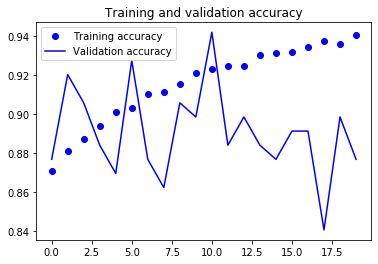

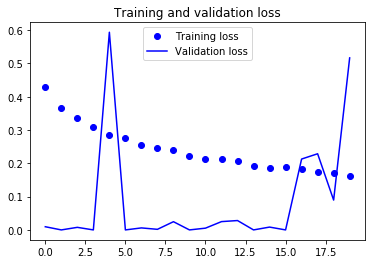

In [77]:
accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Prediction on test Dataset

In [78]:
predict_test=model.predict_generator(generator=testData,verbose=1)

13725/13725 [==============================] - 85s 6ms/step


In [79]:
predicted_testclasses = np.argmax(predict_test, axis=1)

In [80]:
true_testclasses = testData.classes

In [81]:
confusion_test = confusion_matrix(true_testclasses, predicted_testclasses)
print(confusion_test)

[[ 37   0   0 ...   0   0   0]
 [  0 227   0 ...   0   0   0]
 [  0   0  19 ...   0   0   0]
 ...
 [  0   0   0 ...  18   0   0]
 [  0   0   0 ...   0 291   0]
 [  0   4   0 ...   0   0 833]]


In [82]:
print(classification_report(true_testclasses,predicted_testclasses))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       0.96      0.95      0.96       238
           2       0.68      0.68      0.68        28
           3       0.97      1.00      0.99       268
           4       0.81      0.76      0.79        17
           5       0.97      0.99      0.98       157
           6       0.79      0.68      0.73        22
           7       0.94      0.99      0.96       280
           8       0.75      0.69      0.72        13
           9       0.69      0.79      0.74        58
          10       0.93      0.89      0.91        93
          11       0.87      0.83      0.85       939
          12       0.45      0.50      0.48        10
          13       0.79      0.62      0.69        95
          14       0.97      0.97      0.97        35
          15       0.74      0.65      0.69       153
          16       0.94      0.59      0.72        29
          17       1.00    

# Prediction on Train Dataset

In [83]:
predict_train=model.predict_generator(generator=trainData,verbose=1)

279/279 [==============================] - 161s 577ms/step


In [84]:
predicted_trainClasses = np.argmax(predict_train, axis=1)

In [85]:
true_trainclasses = trainData.classes

In [86]:
confusion_train = confusion_matrix(true_trainclasses, predicted_trainClasses)
print(confusion_train)

[[  74    0    0 ...    0    0    0]
 [   0  482    0 ...    0    0    0]
 [   0    0   56 ...    0    0    0]
 ...
 [   0    0    0 ...  130    0    0]
 [   0    0    0 ...    0  624    0]
 [   0    0    0 ...    0    0 1701]]


In [87]:
print(classification_report(true_trainclasses,predicted_trainClasses))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        74
           1       1.00      1.00      1.00       482
           2       1.00      0.98      0.99        57
           3       1.00      1.00      1.00       545
           4       1.00      0.97      0.99        35
           5       1.00      1.00      1.00       320
           6       0.98      1.00      0.99        44
           7       0.98      1.00      0.99       569
           8       1.00      1.00      1.00        26
           9       0.99      1.00      1.00       117
          10       1.00      1.00      1.00       190
          11       0.98      0.96      0.97      1907
          12       1.00      1.00      1.00        20
          13       0.99      0.95      0.97       194
          14       1.00      1.00      1.00        71
          15       1.00      0.99      1.00       311
          16       1.00      1.00      1.00        59
          17       1.00    

# Feature Extraction

In [88]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

In [93]:
feature_model = Model(inputs=model.inputs,outputs=model.get_layer('leaky_re_lu_3').output)
feature_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0   

In [101]:
train_feature=feature_model.predict_generator(trainData,verbose=1)
train_feature=pd.DataFrame(train_feature)

279/279 [==============================] - 104s 371ms/step


In [102]:
test_feature=feature_model.predict_generator(testData,verbose=1)
test_feature=pd.DataFrame(test_feature)

13725/13725 [==============================] - 723s 53ms/step


train_feature.to_csv('Features/articleType_train_feature.csv')
test_feature.to_csv('Features/articleType_test_feature.csv')

train_feature=pd.read_csv('Features/articleType_train_feature.csv')
test_feature=pd.read_csv('Features/articleType_test_feature.csv')

train_feature.columns
test_feature.columns

train_feature.drop('Unnamed: 0', axis=1, inplace=True)
test_feature.drop('Unnamed: 0', axis=1, inplace=True)

In [137]:
test_feature = pd.concat([testdf,test_feature], axis =1)
train_feature = pd.concat([traindf,train_feature], axis =1)

In [138]:
print(test_feature.head())
print(train_feature.head())

    FileName   articleType   FileName   articleType         0         1  \
0  33866.jpg       Sandals  33866.jpg       Sandals  1.723783 -0.860014   
1  50025.jpg      Leggings  50025.jpg      Leggings -0.155427  4.518893   
2  32554.jpg  Casual Shoes  32554.jpg  Casual Shoes -1.136081 -0.945507   
3  18586.jpg         Socks  18586.jpg         Socks  5.168271 -0.887530   
4  41760.jpg          Tops  41760.jpg          Tops -0.325462 -0.656366   

          2         3         4         5  ...        54        55        56  \
0 -1.615898  3.739750 -0.223499 -1.545060  ... -1.903793 -1.974984 -0.827429   
1 -0.138679 -0.448933  4.443844 -0.536743  ... -1.635222  1.436128  5.952700   
2  8.214421  2.414149  1.380901 -1.812141  ... -0.647217 -0.811333 -0.012900   
3 -0.943794  1.930262  9.077977 -0.317978  ... -1.794136 -0.132944 -1.837919   
4 -1.302325 -1.679177 -0.590092  8.231873  ... -0.290987 -0.645975 -1.595061   

         57         58        59         60        61        62     

In [128]:
train_feature.to_csv('Features/articleType_train_feature.csv', index = False, header=True)
test_feature.to_csv('Features/articleType_test_feature.csv', index = False, header=True)

In [139]:
tr=pd.read_csv('Features/articleType_train_feature.csv')
te=pd.read_csv('Features/articleType_test_feature.csv')
tr.columns
te.columns

Index(['FileName', 'articleType', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56',
       '57', '58', '59', '60', '61', '62', '63'],
      dtype='object')

In [140]:
te.head()

,FileName,articleType,0,1,2,3,4,5,6,7,...,54,55,56,57,58,59,60,61,62,63
0,33866.jpg,Sandals,1.723783,-0.860014,-1.615898,3.739750,-0.223499,-1.545060,-2.038923,4.781416,...,-1.903793,-1.974984,-0.827429,-0.402110,-0.510859,-0.284058,13.142218,-0.933474,-1.051266,-2.520883
1,50025.jpg,Leggings,-0.155427,4.518893,-0.138679,-0.448933,4.443844,-0.536743,-0.419763,-0.568726,...,-1.635222,1.436128,5.952700,-0.515755,-0.131185,1.875632,-0.799602,-0.353044,-0.216098,5.356925
2,32554.jpg,Casual Shoes,-1.136081,-0.945507,8.214421,2.414149,1.380901,-1.812141,-0.695216,7.670508,...,-0.647217,-0.811333,-0.012900,-0.857983,-0.843543,-0.717267,10.146515,-0.327790,-0.195848,-2.402055
3,18586.jpg,Socks,5.168271,-0.887530,-0.943794,1.930262,9.077977,-0.317978,3.701172,-0.681807,...,-1.794136,-0.132944,-1.837919,-0.865581,11.828217,-1.296289,10.060918,9.186461,-0.150009,0.875939
4,41760.jpg,Tops,-0.325462,-0.656366,-1.302325,-1.679177,-0.590092,8.231873,-0.865028,-0.233852,...,-0.290987,-0.645975,-1.595061,0.332112,-0.314031,-1.884106,-2.075674,-0.166719,0.916276,-1.121908


In [131]:
mod=load_model('Models/articleType_model.h5')
print(mod.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

In [132]:
feature_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0   

In [135]:
feature_model.save('Models/articleType_featureExtractor.h5')

In [136]:
fmod=load_model('Models/articleType_featureExtractor.h5')
fmod.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0   